# Decision Tree Lab

In [199]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn import tree

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [266]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self):
      self.information_gains_splits = []
      self.tree = {}
      self.most_common_guess = None
        

    def fit(self, data, classes, feature):
      self.tree = self.make_tree(data,classes,feature)

      vals, freq = np.unique(classes, return_counts=True)
      self.most_common_guess = vals[np.argmax(freq)]

      return self

    def calc_entropy(self, p):
      if p != 0:
        return -p * np.log2(p)
      else:
        return 0

    def calc_entropy_gain(self, p):
      if p != 0:
        return p * np.log2(p)
      else:
        return 0

    def calc_info_gain(self, data, classes, feature):
      gain = 0
      nData = len(data)

      values = []

      # Get list of unique values in the current feature
      for datapoint in data:
        if datapoint[feature] not in values:
          values.append(datapoint[feature])

      featureCounts = np.zeros(len(values))
      entropy = np.zeros(len(values))
      valueIndex = 0

      # Iterate through each unique value
      for value in values:
        dataIndex = 0
        newClasses = []

        # Loop through each row of the data
        for datapoint in data:
          if datapoint[feature] == value:  # If the current value of the row matches the value
            featureCounts[valueIndex] += 1
            newClasses.append(classes[dataIndex]) # Match up class of the current row with the current value
          dataIndex += 1

        classValues = []

        for aclass in newClasses:
          if classValues.count(aclass) == 0:
            classValues.append(aclass)

        classCounts = np.zeros(len(classValues))
        classIndex = 0

        for classValue in classValues:
          for aclass in newClasses:
            if aclass == classValue:
              classCounts[classIndex] += 1
          classIndex += 1
        
        for classIndex in range(len(classValues)):
          p = classCounts[classIndex] / sum(classCounts)
          entro = self.calc_entropy_gain(p)
          entropy[valueIndex] += entro

        entropy[valueIndex] = -1 * entropy[valueIndex]

        # Gain works for now, see if it needs adjusting later
        gain += float(featureCounts[valueIndex])/nData * entropy[valueIndex]
        valueIndex += 1

      return gain

    def make_tree(self, data, classes, featureNames):    
      nData = len(data)
      nFeatures = len(featureNames)

      unique_classes, frequency = np.unique(classes, return_counts=True)

      default = unique_classes[np.argmax(frequency)]

      # Check for completely empty array
      if nData == 0 or nFeatures == 0:
        return default

      # Only one class is left
      elif frequency[0] == nData:
        return classes[0]

      else:      
        probablities = frequency / nData

        totalEntropy = 0
        for p in probablities:
          totalEntropy += self.calc_entropy(p)

        gain = np.zeros(nFeatures)
        
        for feature in range(nFeatures):
          g = self.calc_info_gain(data, classes, feature)
          gain[feature] = totalEntropy - g

        bestFeature = np.argmax(gain)
        tree = {}

        self.information_gains_splits.append(gain[bestFeature])
      
        bestFeatureColumn = data[:, bestFeature]
        values = np.unique(bestFeatureColumn)
        

        # Make splits for each sub tree from the selected best feature
        for value in values:
          index = 0
          newData = []
          newClasses = []
          newNames = []

          # Loop through each row of the data
          for datapoint in data:

            # Find data points with each feature value
            if datapoint[bestFeature] == value:
              next_datapoint = []

              for i in range(nFeatures):
                # Don't add values from best feature column
                if i == bestFeature:
                  continue

                # Append each value from the datapoint except the best feature
                next_datapoint.append(datapoint[i])


              newData.append(next_datapoint)
              newClasses.append(classes[index])

            index += 1

          # Get updated list of feature names for next recursion
          for i in range(nFeatures):
                # Don't add values from best feature column
                if i == bestFeature:
                  continue
                
                newNames.append(featureNames[i])

          outData = np.asarray(newData)
          
          subtree = self.make_tree(outData, newClasses, newNames)
          tree_string = featureNames[bestFeature] + " = " + str(value)

          tree[tree_string] = subtree 

        return tree

    def predict(self, X, features):
      predictions = []

      

      for datapoint in X:
        start_tree = self.tree
        prediction = self.predict_value(datapoint, start_tree, features)

        if prediction is None:
          prediction = self.most_common_guess

        predictions.append(prediction)

      return predictions
    
    def predict_value(self, datapoint, tree, featureNames):
      prediction = None

      for key, value in tree.items():

        split_key = key.split()

        feature = split_key[0]
        value_to_match = split_key[2]

        datapoint_index = np.where(featureNames == feature)[0][0]
        check_value = datapoint[datapoint_index]


        # This is the correct branch of the tree to traverse
        if value_to_match == check_value:

          # If value is a dictionary, recurse to the next layer
          if isinstance(value, dict):
            prediction = self.predict_value(datapoint, value, featureNames)

          # If value is a string, this is the predicted output, return it
          else:
            return value


      return prediction


    def score(self, X, y):
      total_vals = 0
      total_correct = 0

      for i in range(len(y)):
        predicted = X[i]
        actual = y[i]

        if predicted == actual:
          total_correct += 1
        total_vals += 1

      
      return round(total_correct / total_vals, 3)

    def get_info_gains(self):
      return self.information_gains_splits
    
    def get_tree(self):
      return self.tree

    def print_tree(self):
      starting_tree = self.tree

      counter = -1
      self.recursive_print(starting_tree, counter)

    def recursive_print(self, tree, counter):
      counter += 1   
      for key, value in tree.items():
        tabs = ""
        for i in range(counter):
          tabs += '    '

        if isinstance(value, dict):
          string_out = tabs + key + ":"
          print(string_out)
          self.recursive_print(value, counter)
        else:
          out_1 = tabs + key
          print(out_1)
          tabs += '    '
          out_2 = tabs + "prediction: " + value
          print(out_2)


## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset (lenses.arff)](https://byu.instructure.com/courses/14142/files?preview=4622251)

Test your model on the lenses test set: [Debug Test Dataset (lenses_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622254)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260)

*NOTE: The [Lenses Prediction (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [267]:
# Load debug training data 
raw_data = loadarff('lenses.arff')
df = pd.DataFrame(raw_data[0])


for column in df.columns:
  df[column] = df[column].str.decode("utf-8")

# Get data into X, y
featureNames = df.columns.values
label_name = featureNames[-1]

# Get array of feature names except the label column
featureNames = featureNames[:-1]

# Get X and y values from pandas dataframe
X = df.values
y = df[label_name].values


# Initialize decision
model = DTClassifier()

# Train Decision Tree
model.fit(X,y, featureNames)

# Print tree
print("Printing tree: ")
model.print_tree()

# Print the information gain of every split you make.
print("\nInformation gains for each split: ")
print(model.get_info_gains())

# Predict and compute model accuracy

# Load test dataset
raw_data = loadarff('lenses_test.arff')
df = pd.DataFrame(raw_data[0])

for column in df.columns:
  df[column] = df[column].str.decode("utf-8")

# Get data into X, y
featureNames = df.columns.values
label_name = featureNames[-1]

# Get array of feature names except the label column
featureNames = featureNames[:-1]

# Get X and y values from pandas dataframe
X = df.values
X = X[:, :-1]
y = df[label_name].values

# Predict and Score Model accuracy
print("\nModel accuracy on Lenses Dataset")
print(model.score(model.predict(X, featureNames), y))

Printing tree: 
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope
                prediction: soft
            spectacle_prescrip = myope
                prediction: none
        age = young
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic
                prediction: none
            age = presbyopic
                prediction: none
            age = young
                prediction: hard
        spectacle_prescrip = myope
            prediction: hard
tear_prod_rate = reduced
    prediction: none

Information gains for each split: 
[0.5487949406953982, 0.7704260414863778, 0.3166890883150208, 1.0, 0.4591479170272448, 0.9182958340544896]

Model accuracy on Lenses Dataset
0.333


## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset (zoo.arff)](https://byu.instructure.com/courses/14142/files?preview=4622270)

Test your model on this dataset: [Evaluation Test Dataset (zoo_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622274)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [268]:
# Load debug training data 
raw_data = loadarff('zoo.arff')
df = pd.DataFrame(raw_data[0])


for column in df.columns:
  df[column] = df[column].str.decode("utf-8")

# Get data into X, y
featureNames = df.columns.values
label_name = featureNames[-1]

# Get array of feature names except the label column
featureNames = featureNames[:-1]

# Get X and y values from pandas dataframe
X = df.values
y = df[label_name].values


# Initialize decision
model = DTClassifier()

# Train Decision Tree
model.fit(X,y, featureNames)

# Print tree
print("Printing tree: ")
model.print_tree()

# Print the information gain of every split you make.
print("\nInformation gains for each split: ")
print(model.get_info_gains())

# Predict and compute model accuracy

# Load test dataset
raw_data = loadarff('zoo_test.arff')
df = pd.DataFrame(raw_data[0])

for column in df.columns:
  df[column] = df[column].str.decode("utf-8")

# Get data into X, y
featureNames = df.columns.values
label_name = featureNames[-1]

# Get array of feature names except the label column
featureNames = featureNames[:-1]

# Get X and y values from pandas dataframe
X = df.values
X = X[:, :-1]
y = df[label_name].values

# Predict and Score Model accuracy
print("Model accuracy on Zoo Dataset")
print(model.score(model.predict(X, featureNames), y))


Printing tree: 
legs = 0:
    fins = F:
        toothed = F
            prediction: c7
        toothed = T
            prediction: c3
    fins = T:
        eggs = F
            prediction: cT
        eggs = T
            prediction: c4
legs = 2:
    hair = F
        prediction: c2
    hair = T
        prediction: cT
legs = 4:
    hair = F:
        predator = F
            prediction: c3
        predator = T:
            toothed = F
                prediction: c7
            toothed = T
                prediction: c5
    hair = T
        prediction: cT
legs = 5
    prediction: c7
legs = 6:
    predator = F
        prediction: c6
    predator = T
        prediction: c7
legs = 8
    prediction: c7

Information gains for each split: 
[1.3630469031539394, 0.8865408928220899, 0.9852281360342515, 0.6962122601251459, 0.8256265261578954, 0.6892019851173656, 0.8631205685666308, 0.7219280948873623, 0.7219280948873623]
Model accuracy on Zoo Dataset
0.147


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criterion, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [196]:
import random

# Write a function that implements 10-fold cross validation
def k_fold_verification(n_folds, df):
  # Save feature names from data frame
  featureNames = df.columns.values

  # Get array of feature names except the label column
  featureNames = featureNames[:-1]

  indicies = df.index.tolist()
  
  partition_size = len(indicies) // n_folds

  # Break up test set into 10 partitions
  partitions = []

  data = df.values

  for i in range(n_folds):
    # Create new partition to hold data values
    current_partition = []

    # Get random sample of indicies to add to this partition
    partition_indicies = random.sample(population=indicies, k=partition_size)

    # Add data for each index to current partition array
    for index in partition_indicies:
      current_partition.append(data[index])

      # remove index from indicies array
      indicies.remove(index)

    partitions.append(current_partition)


  
  # Initialize validation accurarcy array
  validation_accuracies = []
  best_tree = None
  best_accuracy = 0

  # Loop for number of partition, when i == index of partition, make that partiion validation set
  for i in range(n_folds):

    # initialize data arrays
    training_data = []
    validation_data = []

    for j in range(len(partitions)):
      # The current partition is the validation set
      if j == i:
        validation_data = partitions[j]
      # Create training set from other partitions
      else:
        for row in partitions[j]:
          data_to_add = np.asarray(row)
          training_data.append(data_to_add)

    # Send to numpy array for decision tree algorithm
    training_data = np.asarray(training_data)
    validation_data = np.asarray(validation_data)

    # Split into training X, y values
    X = training_data[:, :-1]
    y = training_data[:, -1]
    
    # Initialize model
    model = DTClassifier()

    # Create tree from training data
    model.fit(X, y, featureNames)

    # Process data for validation data set
    X_val = validation_data[:, :-1]
    y_val = validation_data[:, -1]

    # Predict and get accuracy for validation data
    accuracy = model.score(model.predict(X_val, featureNames),y_val)
    print("Accuracy: ", accuracy)
    validation_accuracies.append(accuracy)

    if accuracy > best_accuracy:
      best_model = model
      best_accuracy = accuracy

    

  return validation_accuracies, best_model

##  2.2 Cars Dataset
- Use this [Cars Dataset (cars.arff)](https://byu.instructure.com/courses/14142/files?preview=4622293)
- Make a table for your k-fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [52]:
# Use 10-fold CV on Cars Dataset

# Load debug training data 
raw_data = loadarff('cars.arff')
df = pd.DataFrame(raw_data[0])

for column in df.columns:
  df[column] = df[column].str.decode("utf-8")


# Run 10 fold verification
test_accuracies, best_model = k_fold_verification(10, df)

# Display results in table
print("Average test accuracy: ", round(np.mean(test_accuracies),3))

Accuracy:  0.884
Accuracy:  0.924
Accuracy:  0.895
Accuracy:  0.936
Accuracy:  0.901
Accuracy:  0.919
Accuracy:  0.884
Accuracy:  0.907
Accuracy:  0.913
Accuracy:  0.89
Average test accuracy:  0.905


In [53]:
print("Tree of model with highest test accuracy: ")
best_model.print_tree()

Tree of model with highest test accuracy: 
safety = high:
    persons = 2
        prediction: unacc
    persons = 4:
        buying = high:
            maint = high
                prediction: acc
            maint = low
                prediction: acc
            maint = med
                prediction: acc
            maint = vhigh
                prediction: unacc
        buying = low:
            maint = high:
                lug_boot = big
                    prediction: vgood
                lug_boot = med:
                    doors = 2
                        prediction: acc
                    doors = 3
                        prediction: acc
                    doors = 4
                        prediction: vgood
                    doors = 5more
                        prediction: vgood
                lug_boot = small
                    prediction: acc
            maint = low:
                lug_boot = big
                    prediction: vgood
                lug_boot = med:

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)
- Note that you will need to support unknown attributes in the voting data set. 

In [54]:
# Used 10-fold CV on Voting Dataset

# Load debug training data 
raw_data = loadarff('voting_with_missing.arff')
df = pd.DataFrame(raw_data[0])

for column in df.columns:
  df[column] = df[column].str.decode("utf-8")


# Run 10 fold verification
test_accuracies, best_model = k_fold_verification(10, df)

# Display results in table
print("Average test accuracies: ", round(np.mean(test_accuracies),3))

Accuracy:  0.884
Accuracy:  0.953
Accuracy:  0.953
Accuracy:  0.953
Accuracy:  0.907
Accuracy:  0.93
Accuracy:  0.977
Accuracy:  0.953
Accuracy:  0.93
Accuracy:  0.953
Average test accuracies:  0.939


In [55]:
print("Tree of model with highest test accuracy: ")
best_model.print_tree()

Tree of model with highest test accuracy: 
physician-fee-freeze = ?:
    mx-missile = ?
        prediction: republican
    mx-missile = n
        prediction: democrat
    mx-missile = y:
        anti-satellite-test-ban = ?
            prediction: democrat
        anti-satellite-test-ban = n
            prediction: republican
        anti-satellite-test-ban = y
            prediction: democrat
physician-fee-freeze = n:
    education-spending = ?:
        adoption-of-the-budget-resolution = n
            prediction: republican
        adoption-of-the-budget-resolution = y
            prediction: democrat
    education-spending = n
        prediction: democrat
    education-spending = y
        prediction: democrat
physician-fee-freeze = y:
    synfuels-corporation-cutback = ?
        prediction: republican
    synfuels-corporation-cutback = n:
        export-administration-act-south-africa = ?:
            adoption-of-the-budget-resolution = n
                prediction: republican
     

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

My performance for the two data sets was about what was expected. The average for the cars data set was 90.4% and the average for the voting with missing values was 92.5%, both of which fall into the expected ranges, though on the lower end. 

For fun and to see what happened, I ran the tests many times for both of the datasets. The results stayed generally in the same range, but occasionally would have some drops. This is expected however since we are randomly shuffling the data before assigning it to the partitions. If the test data happens to have more examples which are less familiar to the tree, which is more unlikely since we are using a 9:1 ratio of training to test data, then the test accuracy will suffer since the tree is less sure how to handle it and uses best guess nodes (relying on the majority class for splits) which may or may not be correct. 

I was surprised that the missing values did not affect the performance of the voting dataset more. By treating a missing value as its own feature attribute, the algorithm continued like normal and was still successful in classification. It likely would have performed better with a full data set so it can be precise and have one less potential split to make, but I was still genuinely surprised that a simple treatment of missing data did not affect the success in classification. 

A fully expanded tree often gets 100% on the training data because if there are enough examples to cover each combination of input features, it can expand in a way that creates a branch path for each possibility that is represented in the training data. This is especially common if there is only one or very few examples of each possible input feature combination in the data, as is the case with the smaller data sets from above like the lenses data set. The tree never has to really make "hard" decisions since often the resulting data class after all of the splits is pure, so it can just apply a blanket case that covers all of the input examples. If the inputs are varied and have enough examples, then a deep tree can still do well in predicting test data, as was seen with the 10 fold validation examples. Restricting the number of layers of depth, or pruning the tree can help preven this overfitting to the training data. 

Some cases where a decision tree might not get 100% on the training data include working with continuous data instead of categorical data, or if there are 50/50 cases in the data. With the continuous data cases, since splits have to be made at the space between points, there is a lot more room for cases that are close to the borders to be miscategorized since it is hard to partition the data along those continuous lines in a linear fashion. The decision tree just has to do what will get the most points within the boundaries. As for the 50/50 cases, for example, when a tree has split betweeen all of the input features, there are cases where it may be left with equal cases of different output classes (not pure). In these cases, depending on how the algorithm is implemented, it could choose to predict these examples as the most common class overall, or by some other method. However, no matter the decision making practice, since there is no further way to split the data, it becomes impossible to algorithmically predict both output classes for identical input features. In these cases, the training data predictions would not be 100%, but still would be close. Its just a matter of what is the best default behavior to ensure the best overall performance for potential test cases.

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e., look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

The tree is fairly deep, so its hard to summarize all of the decisions made. The most important one, the very first split it decided on was on the safety variable. This seems logical, the condition/quality rating of the car would depend heavily on its safety rating; it would be a safe choice for a person selecting splitting variables by logic. All cars with low safety were immediately labeled unacceptable, indicating that the data always found a pure class for low safety. 

After safety, persons was the next variable split on, for both medium and high safety splits. Since safety and persons always came 1/2 in terms of splitting, its safe to recognize the relationship between these two variables as key indicators for predicting the outputs. Even after that, for all splits on safety and persons, buying was always the third split and maintenance was the 4th. This consistency for being organized in the different branches of the tree indicates the strong relationship between these variables and their importance in predicting the output classes, since they always had the highest information gain in each branch and split.

After those, it starts to vary depending on branch. Some of the branches would use lug_boot as the next predictor, some would use doors. Some would need both of those variables in order to reach either a pure class or best prediction, and some would make predictions just off of the 4 previously mentioned variables. This indicates that lug_boot and doors were not always as critical to making the predictions, but were needed at times to classify some of the more uncommon cases. The fact that lug_boot and doors would get switched around means that the data did vary a bit at some of these deeper layers in the tree, compared to the more consistant organization at the first 4 layers.

As for relation to the outputs, as the trees extended, there were examples of almost every output class somewhere along each branch. However, there are some clear distinctions, even from the first splits. Following the first split on safety, almost every leaf node in the tree on the high safetly split is at least acceptable, meaning that the general output was better along the best value of the safety variable. For the medium safety, the eventual output classes were still fairly good, but there are some unacceptables in there. A similar pattern shows for the big variables like maintenance that  have a clear positive to negative range of values and were higher on the decision tree split levels.

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

Unlike the car decision trees, the voting set was more straightforward and did not have as many levels. It did have a few more splits than would normally be expected, since the unknown variables were treated as their own input values represented by a ?. The first value split on the tree was the physician fee freeze value. None of the three values (y,n,?) were able to immediately predict the output class, unlike the car tree that predicted unacceptable for a low safety car. This means that the dataset had more variety in the output classes for similar input values, and the tree needed more levels to start making predictions. The next level of decisions actually varied from each branch of the first split. If physician fee freeze was yes, then the tree looked at synfuels corporation cutbacks as the next variable. For no, education spending was the next choice, and for ? or the unknown branch, the next variable was the mx-missle.

From a logical human perspective, some of these relationships make sense. If you know the physician fee freeze is no, then you are probably looking at mostly democrats, and the tree reflects this. From the first no branch not any of the routes used all of the possible input variables to make predictions. Only one (education spending = ?) needed anymore information to predict republican. In other words, for issues that have pretty clear party lines in U.S. politics, the decision making process can get pretty clear for a decision tree in some cases.

The most complicate routes came from the initial physician fee freeze = y branch of the tree. This would make sense, since while this would be generally republican favored idea, it is not as one-sidedly Republican to say yes here as it is Democratic to say no to the same question. Most of the branches from this part of the tree had to use 4 or 5 input values to reach a decision leaf node, resulting in a much deeper side of the tree than the other splits. There was a lot of variation in the order that the next splitting inputs were selected, and very very few branches needed all the input, indicate a lot of nuance in the data based on specific issues that get grouped together. (i.e. education-spending and budget resolution, or export adminstration act south africa and el-salvador aid). 

The unknown values make things a little different since you can't make an assumption which value it is might actually be if it was filled in, but it is interesting to follow the tree and see where it takes you based on background political knowledge. In most cases, the results are unsurprising. Even if the initial yes on the physican fee is more Republican, if you then follow the corporation cutback yes branch, unsurprisingly, you are led to more Democrat preditions. It is interesting to see that the assembled tree, while based on statistical values like entropy and information gain, does produce output along the lines of what you would assume based on cultural and political knowledge.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

I handled unknown attributes by treating them as a possible value of its own for each feature. Anywhere an unknown attribute appears in the data, it has a question mark. Rather than making a guess or randomly assigning it one of the two classes, I let the question marks be treated as its own value. For example, if normally there are two expected values yes and no, the ? would be a third possible value that would be accounted for when making splits in building the tree.

The disadvantage to this is that each time you split up your data, you are increasing the decisions that need to be made, and thus the likeliness for incorrect classification, especially since missing data values are the minority of the dataset. The question is is it worth considering entire new feature values if it might confuse the decision tree on the output. Based on the results of my testing, the accuracy was still fairly good and within the expected ranges, so I think the approach is not a problem. If accuracy fell, then it would have been better to look at other ways to fix the problem.

Of course, this method is the simplest since Pandas has a fillNA method, so its easy to just put a blanket single value (?, na, or anything else). If accuracy is not a concern, like how my experiments turned out, then it is a very trivial matter to handle unknowns like this. Besides the simplicity of it, I feel like leaving the class as "unknown" maintains the integrity of the dataset more than filling in an arbitrary value from the expected values. If just assigned things as yes or no, that is simply me making a guess (which can be based on some logic or probability). If the decision tree can still learn with the unknown values being treated as values of their own, I think that is more in-line with the data as it was collected, and prevents it from getting skewed a certain way by replacing the values. This can be mitigated by randomly selecting the replacement value from a normal distribution, so there are definitely other valid approaches to solving this issue. Since the accuracy came out fairly well, I felt happy with how things worked out after all.

## 4.1 (10%) Use Scikit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform best on the test set. 

### 4.1.1 sklearn on Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)

In [265]:
raw_data = loadarff('voting_with_missing.arff')
df = pd.DataFrame(raw_data[0])

for column in df.columns:
  df[column] = df[column].str.decode("utf-8")

# Turn categorical data into one hot encodings for scikit learn Decision Tree 
x = df.drop(columns="Class")
x = pd.get_dummies(x)
y = df["Class"]
y = pd.get_dummies(y)


# Train Test Split for training, test data

X_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1, random_state = 42)

clf = DecisionTreeClassifier(random_state = 42, splitter="random")
clf.fit(X_train, y_train)

score = clf.score(x_test, y_test)
print("Accuracy for voting dataset: ", score)

Accuracy for voting dataset:  0.9545454545454546


I started messing around with the max_depth since that is a pretty clear parameter to try and play with. For all of my tests, I used a single fixed random state for the testing split and the classification initialization to keep things simple. I also used a 0.1 split for the test size, since that is what I used in the 10-fold validation (9 sets training to 1 partition of test data), to try and make the comparison as natural as possible between my model and the Sklearn one.

While the general output was in the low 90's to about 92%, I found actually that removing the parameter altogether and just letting the tree build to whatever length is necessary was best. I got a best accuracy of 93.2% that way.

I played with the criterion, switching it to entropy instead of gini, and did not see any change in the accuracy. I mixed this up with changing the max_features to auto, as well as log2, but these changes paired up continued to make the accuracy drop, as low as 88%. When I hard coded max features to 5, the accuracy did climb back up to 90%, but not quite the same highs as before.

Lastly, I tried a test with the defaults (no max_depth, gini for criterion, and no max_features value) and set the splitter to random, and suddenly I got a 95.5%, my highest up to that point. Its interesting that choosing the best random split instead of just the best one as default behavior resulted in a better accuracy performance.

My best accuracy with the Sklearn model thus was 95.5%, about 2% higher than my best outputs with my model. Compared to my model, which uses entropy and chooses the best feature to split and has no depth restrictions, this model used gini and the random splitter. Those two main differences resulted in the 95.5% accuracy over my model, an impressive and not insignificant gain. It would be interesting to try and implement the same 2 different mechanisms (gini and random best splitter) into my model and see if I get the same improvements in my accuracy.

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the sklearn decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [212]:
# Using Sklearn Decision Tree classifier on Titanic Survival dataset

df = pd.read_csv("Titanic.csv")
df.head()

# Data cleaning steps - Use median and mode values to fill in NaN so Sklearn can
# handle one hot encoding outputs.
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

values = {"Age": median_age, "Embarked":mode_embarked}
columns = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"]
df = df.fillna(values)



# Get x and y 
x = df.drop(columns=columns, axis=1)
y = df["Survived"]

# Re-arrange original df to print data set accurately with survived values in last column
df = df.drop(columns=columns)
df["Survived"] = y
print(df)

# One hot encode categorical values for Sklearn classifier
x = pd.get_dummies(x)
y = pd.get_dummies(y)

# Train Test Split for training, test data

best_accuracy = 0
best_rand_class = 0
best_rand_split = 0
for i in range(1000):
  # Train test split
  split_rand_state =  random.randint(0,100)
  X_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1, random_state=split_rand_state)


  # Experiment with different hyper-parameters
  classifier_rand_state = random.randint(0,100)
  clf = DecisionTreeClassifier(max_depth=8, random_state=classifier_rand_state)
  clf.fit(X_train, y_train)

  score = clf.score(x_test, y_test)

  if score > best_accuracy:
    print("Test #: ", i, "New best accuracy for Titanic dataset: ", score)
    best_accuracy = score
    best_rand_class = classifier_rand_state
    best_rand_split = split_rand_state  

     Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Survived
0         3    male  22.0      1      0   7.2500        S         0
1         1  female  38.0      1      0  71.2833        C         1
2         3  female  26.0      0      0   7.9250        S         1
3         1  female  35.0      1      0  53.1000        S         1
4         3    male  35.0      0      0   8.0500        S         0
..      ...     ...   ...    ...    ...      ...      ...       ...
886       2    male  27.0      0      0  13.0000        S         0
887       1  female  19.0      0      0  30.0000        S         1
888       3  female  28.0      1      2  23.4500        S         0
889       1    male  26.0      0      0  30.0000        C         1
890       3    male  32.0      0      0   7.7500        Q         0

[891 rows x 8 columns]
Test #:  0 New best accuracy for Titanic dataset:  0.7555555555555555
Test #:  1 New best accuracy for Titanic dataset:  0.8222222222222222
Test #:  7 New best 

In [213]:
print("Best accuracy from running 1000 random tests: ", best_accuracy)
print("Best random state for train test split: ", best_rand_split)
print("Best random state for Sklearn Decision Tree Classifier: ", best_rand_class)

Best accuracy from running 1000 random tests:  0.9111111111111111
Best random state for train test split:  74
Best random state for Sklearn Decision Tree Classifier:  40


Initially, when I ran the classification tree using default values and randomly generated states for the train/test split function and the decision tree initializations, most of my accuracy tests for the Titanic dataset were somewhere between 75% and 82%. Once I found a random state pairing that resulted in fairly good accuracy values (splitting random state=5, decision tree random state = 41 got me around  83% accuracy), I started messing with different hyper parameters to see what would improve the results. 

Changing the depth of the tree had interesting results. The accuracy would fluctuate a bit when I would reduce the size. By default the max_depth was 8 since there were 8 input values to split on. Some values like 5 and 6 gave prediction accuracies in the high 70's. 3 actually gave me the best results for max_depth. With a depth of 3, the prediction accuracy was 84.3%, my best so far.

I tried messing with criterion="entropy" instead of gini and with the max_features="log2", but no luck. I did get 84.3% with the criterion set to entropy and the max_depth increased by 1 to 4. But it only tied my best prediction accuracy.

I also tried messing around with the way I was handling missing values. Sklearn was mad about having NaN values in the categorical variables columns since they didn't encode into one hot values, so I had to do something. I couldn't just do a ? for a continuous variable like age, so I used the median value to replace any NaN's for age. For the other two categorical variables, I original was using the median from the dataframe to fill the values in, just to try and see. I tried my previous method of just using a ? to fill in the values, but it did not change the output accuracy at all from what I've seen. 

Despite trying different hyper parameters and random states of the training and test splits, the best I was able to do was the same 84.3%. As a last resonrt, I tried a brute force of just running 1000 randomized tests to see what was the best accuracy after trying various random state combinations with the settings of max_depth=3 and the rest default to see if there was anything else out there.I did manage to get one test with 87.7% accuracy, which is not an insignificant improvement over 84.3%. The results overall just varied somewhere in the 80-87% range and varied a lot on the splits for the data. 

I even tried this method with the max_depth back to default size (8) and did actually get to an accuracy of 89%. It seems like 3 was producing more consistent results across the random states, but having the depth large enough to expand the tree as needed seems to be the best choice if training time isn't a problem.

Playing with the training and test splits also improved it just a little bit more. Using a 9:1 train/test ratio intead of 8:2 or 7.5:2.5, I now had an accuracy of 91.1%. Not bad from the original peak of 84.3%

As a last ditch effort, I tried dropping some more columns of categorical data, but did not manage to beat the previous high. 

The ultimate best accuracy I was able to find after all of that then was 91.1% using random states generated in a loop and max_depth=8 and the train test split ratio at .1.









## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first few levels (e.g., top 5).

In [245]:
df = pd.read_csv("Titanic.csv")
df.head()

# Data cleaning steps - Use median and mode values to fill in NaN so Sklearn can
# handle one hot encoding outputs.
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

values = {"Age": median_age, "Embarked":mode_embarked}
columns = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"]
df = df.fillna(values)

# Get x and y 
x = df.drop(columns=columns)
y = df["Survived"]

# Re-arrange original df to print data set accurately with survived values in last column
df = df.drop(columns=columns)
df["Survived"] = y

print(df)

labels = y.unique()

# One hot encode categorical values for Sklearn classifier
x = pd.get_dummies(x)
y = pd.get_dummies(y)

feature_names = x.columns
print("feature names", feature_names)
print("labels: ", labels)


# Train Test Split for training, test data
split_rand_state = 74
X_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1, random_state=split_rand_state)


# Experiment with different hyper-parameters
classifier_rand_state = 40
clf = DecisionTreeClassifier(max_depth=8, random_state=classifier_rand_state)
clf.fit(X_train, y_train)

score = clf.score(x_test, y_test)
print("Score on Titanic dataset: ", score)

     Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Survived
0         3    male  22.0      1      0   7.2500        S         0
1         1  female  38.0      1      0  71.2833        C         1
2         3  female  26.0      0      0   7.9250        S         1
3         1  female  35.0      1      0  53.1000        S         1
4         3    male  35.0      0      0   8.0500        S         0
..      ...     ...   ...    ...    ...      ...      ...       ...
886       2    male  27.0      0      0  13.0000        S         0
887       1  female  19.0      0      0  30.0000        S         1
888       3  female  28.0      1      2  23.4500        S         0
889       1    male  26.0      0      0  30.0000        C         1
890       3    male  32.0      0      0   7.7500        Q         0

[891 rows x 8 columns]
feature names Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object'

In [239]:
# Include decision tree visualization here
tree.export_graphviz(clf, feature_names=feature_names, out_file="tree_graph", class_names=labels)

In [240]:
import pydot

(graph,) = pydot.graph_from_dot_file('/content/tree_graph')
graph.write_png('tree.png')

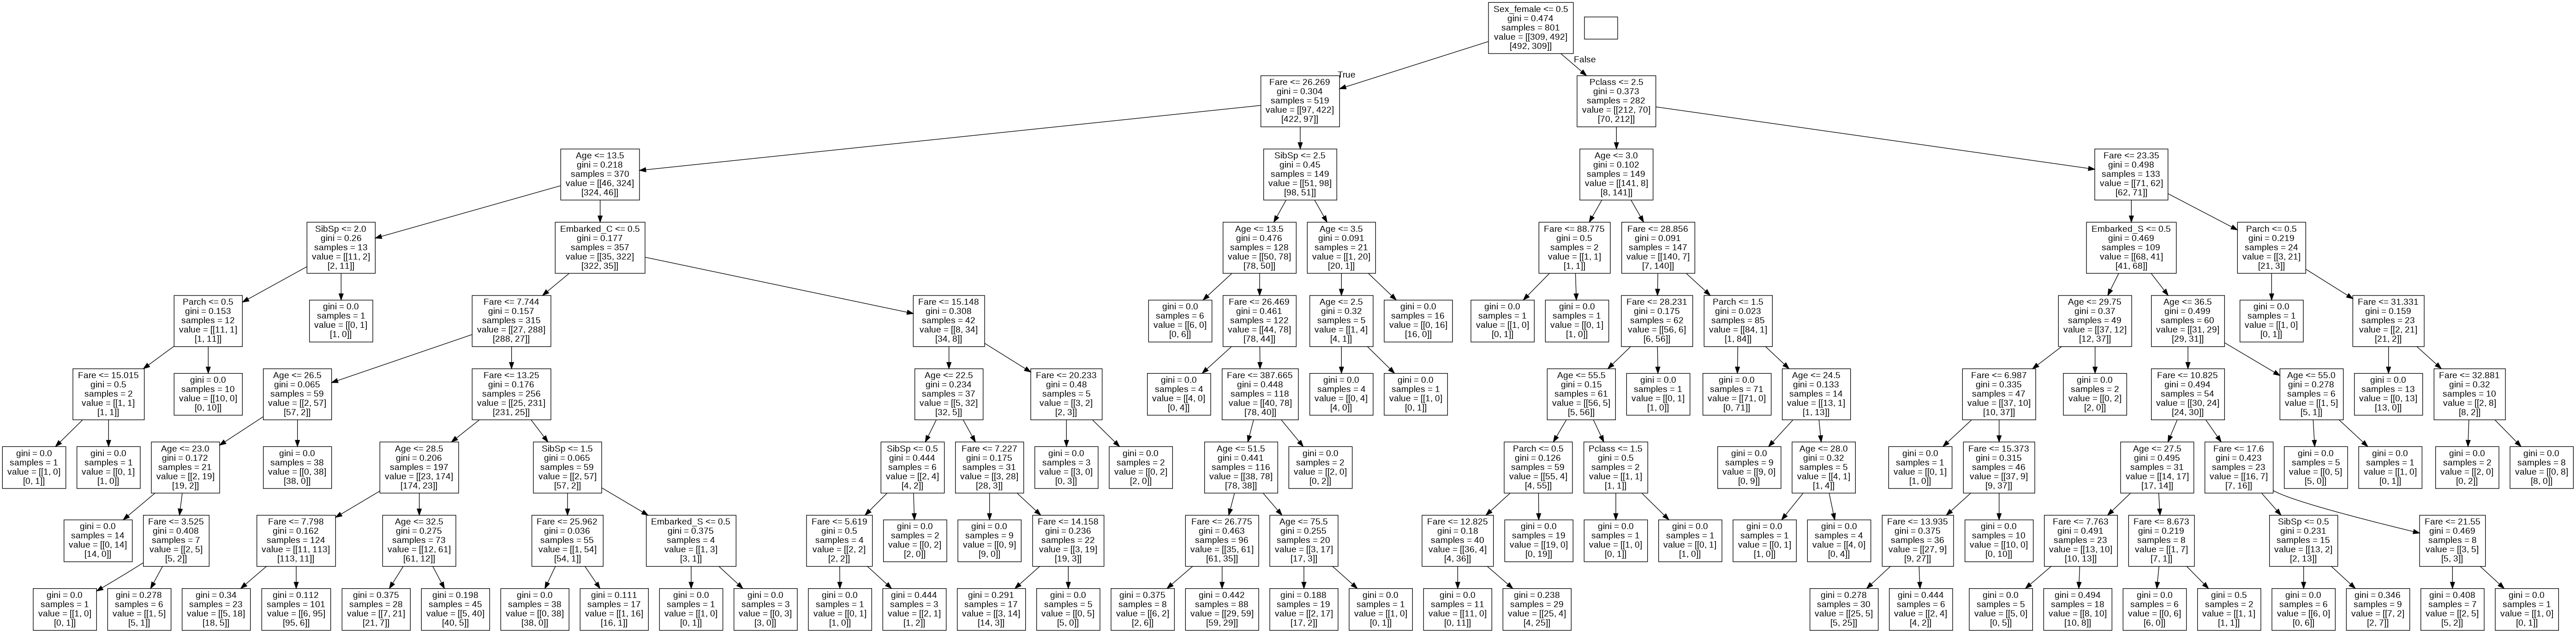

In [241]:
from IPython.display import Image
Image('tree.png')

# Tree is loaded as a png, that can be zoomed in on by clicking.

Looking at the tree vizualiation, it was actually very interesting to see what was actually being used for decision making. The dataset is of mixed types, mostly categorical variables, but a few continuous variables (fare and age). Despite passing the categorical data as one hot encodings, it turns out my decision tree was never really relying on them to make decisions. Instead it completely honed in on the continous variables to make pretty much every decision. Some of the other categorical variables got used a little bit. The very first split was on the sex variable, and Parch, Passenger Class, and Embarkation location variables also appeared on the tree. Still for the most part, splits along the values of the continues variables did the most to help navigate through the examples and predict output. This surprised me since I just blanket assumed from my experience coding my tree that it would try to look at most variables, but it did not in actuality.

Very interestingly, the value taken first for the first split was sex=Female. The fact that sex was one of the most significant variables for predicting survival on the Titanic is interesting, given that we know from historical context that women and children were boarded onto the lifeboats first. Its interesting how prevalent fare and age played a role in the models predictions also. On one hand, its hard to read too deep into things since just the fact that they are continuous variables makes it a easy to make deeper and deeper partitions to isolate and group datapoints, so its not surprising the algorithm honed in on that. On the other hand, these values are not entirely independent from ther variables. Fare is related to things like embarkation location, passenger class and likely age as well, since older folks with more money likely paid higher fares. Age similarly makes sense from context too, as older people would be prioritized in a rescue/evacuation mission.

In the end, I was just caught off guard when I saw the tree and realized it was essentially decided everything from the two continuous variables. A couple other ones were used for big information splits, but generally speaking, age and fare really did most of the heavy lifting here.